# Learning how and when to communicate with CommNet

## Lever Task

In [1]:
# necessary imports
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# we import our CommNet implementation for the lever task and a commnet environment
from commnet import CommNetLever
from env import LeverEnv

/Users/felixgaschi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Supervised learning

We first train our CommNet in a supervised way.

In [3]:
def generate_data(n, N, J):
    
    '''
    Generates data for supervised learning
    
    '''
    
    X = np.empty((n, J), dtype = int)
    y= np.empty((n,J), dtype = int)
    
    for i in range(n):
        
        X[i] = np.random.choice(N, size = J, replace = False)
        sorted_args = np.argsort(X[i])
        y[i] = np.argsort(sorted_args)
        
    return X, y

In [4]:
N = 500
J = 5

In [5]:
batch_size = 64
n = batch_size * 50000
X, y = generate_data(n, N, J)
val_X, val_y = generate_data(500, N, J)
test_X, test_y = generate_data(100000, N, J)

In [6]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNetLever(sess, N, J, lr = 1e-3, embedding_size= 128, training_mode = 'supervised')
    env = LeverEnv(N, J)
    commNet.supervised_train(X, y, val_X, val_y, env, batch_size = batch_size, epochs = 1)
    rv = sess.run(commNet.hidden_layers, feed_dict={commNet.inputs: test_X, commNet.targets: test_y})

Epoch: 1: 100%|██████████| 50000/50000 [07:05<00:00, 117.45it/s]


loss = 0.031222
reward = 0.988431

val loss = 0.004058
val reward = 0.998000


In [7]:
def get_coefs(rv, X, key, N, dim=128):
    
    stat = np.zeros((N,128))
    ns = np.zeros((N,))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            k = X[i,j]
            ns[k] += 1
            stat[k] += rv[key][j][i]

    for k in range(N):
        stat[k] /= max(1, ns[k])
    
    return stat

In [8]:
h0_stat = get_coefs(rv, test_X, "h0_seq", N)
h1_stat = get_coefs(rv, test_X, "h1_seq", N)

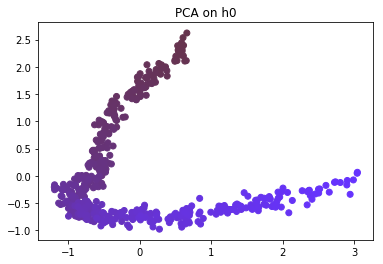

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

new_h0 = pca.fit_transform(h0_stat)
sc = plt.scatter(new_h0[:,0], new_h0[:,1],c=np.array([[0.4,0.2,0.3 + i * 0.7 /new_h0.shape[0], 1.] for i in range(new_h0.shape[0])]))
plt.title("PCA on h0")
plt.savefig("PCA_h0_lever.png", dpi=300)
plt.show()

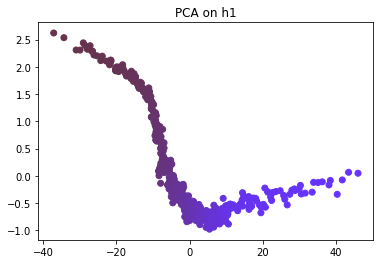

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

new_h1 = pca.fit_transform(h1_stat)
sc = plt.scatter(new_h1[:,0], new_h0[:,1],c=np.array([[0.4,0.2,0.3 + i * 0.7 /new_h1.shape[0], 1.] for i in range(new_h1.shape[0])]))
plt.title("PCA on h1")
plt.savefig("PCA_h1_lever.png", dpi=300)
plt.show()

### REINFORCE

In [7]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNetLever(sess, N, J, lr = 1e-3, embedding_size= 128, training_mode = 'reinforce')
    env = LeverEnv(N, J)
    
    history = commNet.reinforce_train(env, n_episodes = 50000, T =64)

REINFORCE: 100%|██████████| 50000/50000 [1:17:41<00:00, 10.73it/s]


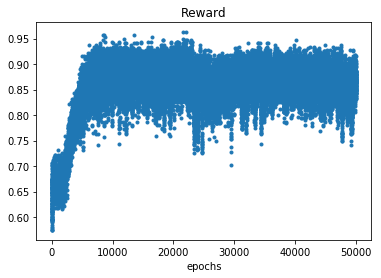

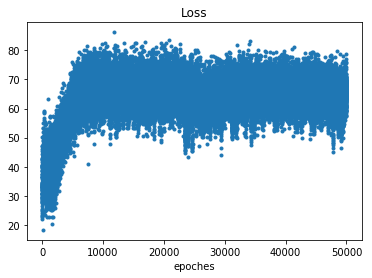

In [8]:
plt.title('Reward')
plt.plot(history['reward'], '.')
plt.xlabel('epochs')
plt.show()
plt.title('Loss')
plt.plot(history['loss'], '.')
plt.xlabel('epoches')
plt.show()

## Predator-prey

In [2]:
# We import our CommNet model for Predator Prey pursuit
from commnet import CommNetPP

# We import the PredatorPreyTask environment 
from env import PredatorPreyTask
from utils import plot_episode

### Without communication cost

t. state: 1.0: 100%|█████████▉| 49996/50000 [22:16<00:00, 48.08it/s] 

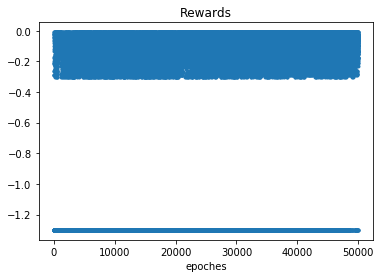

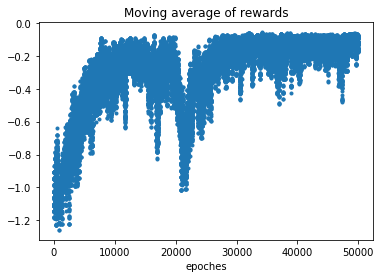

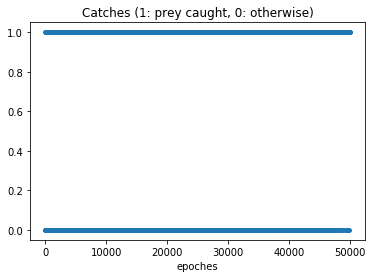

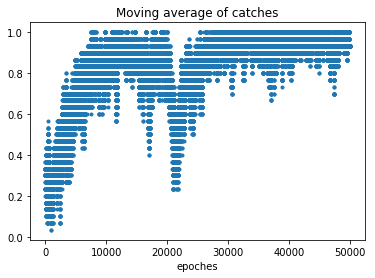

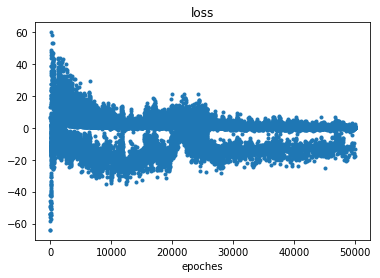

Computing stats: 100%|██████████| 100/100 [00:01<00:00, 70.03it/s]

Avg catches: 0.970
Avg episode lenght: 8.670
Avg number of agent seeing the prey 0.806
Avg communication: 0.586
Avg communication decision when prey seen: 0.674
Avg communication decision when prey not seen: 0.549


In [3]:
N = 3
grid_size = 5
T = 30
n_episodes = 50000

if "sess" in locals():
    sess.close()
    print("Sess closed")
tf.reset_default_graph()
sess = tf.Session()

commNet = CommNetPP(sess, N,  grid_size, lr=1e-3, alpha=0.06, memory = True)
env = PredatorPreyTask(N=N, grid_size=grid_size, detection_range=3, communication_cost=0.00, step_cost=0.01, forbidden_cost=0.,
                       prey_detection_range=1, uncatched_cost=1., T=T, restart_range = 5)
history = commNet.reinforce_train(env, n_episodes=n_episodes, T=T)

W = 30

plt.title("Rewards")
plt.plot(history['reward'], '.')
plt.xlabel('epoches')
plt.show()

plt.title("Moving average of rewards")
plt.plot(np.convolve(history['reward'], np.ones(W), 'valid')/W, '.')
plt.xlabel('epoches')
plt.show()

plt.title("Catches (1: prey caught, 0: otherwise)")
plt.plot(history['terminal_state'], '.')
plt.xlabel('epoches')
plt.show()

plt.title("Moving average of catches")
plt.plot(np.convolve(history['terminal_state'],
                     np.ones(W), 'valid')/W, '.')
plt.xlabel('epoches')
plt.show()    

plt.title("loss")
plt.plot(history['loss'], '.')
plt.xlabel('epoches')
plt.show()

commNet.get_stats(100, T, env)


Catched: True


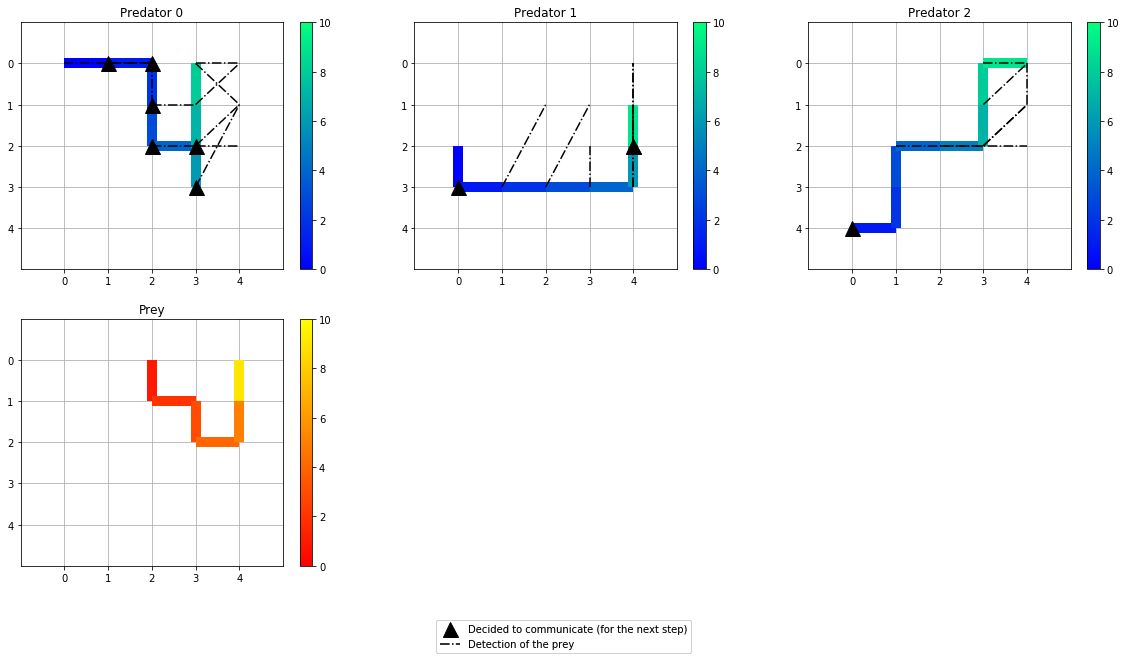

In [4]:
rollout = commNet.policy_rollout(T, env)

print("\nCatched: %s" % bool(rollout['terminal_state']))

pred_coord_history = np.array(env.pred_coord_history)
prey_coord_history = np.array(env.prey_coord_history)
comm_action_history = np.array(env.comm_action_history)
vision_history = np.array(env.vision_history)
plot_episode(pred_coord_history, prey_coord_history,
             comm_action_history, vision_history, grid_size)

In [5]:
!notifier

t. state: 1.0: 100%|██████████| 50000/50000 [22:30<00:00, 48.08it/s]

### With communication cost

Sess closed


t. state: 0.9: 100%|█████████▉| 49995/50000 [19:50<00:00, 54.64it/s]

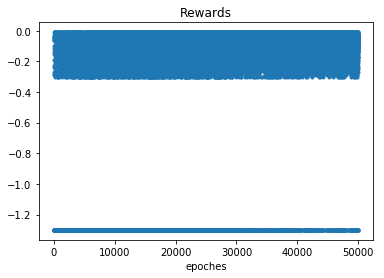

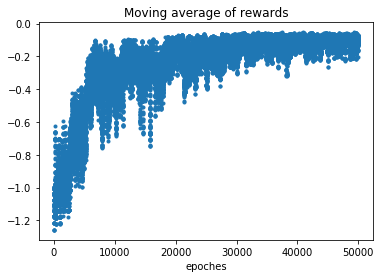

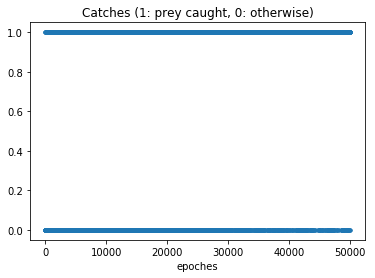

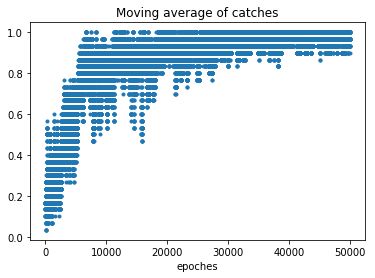

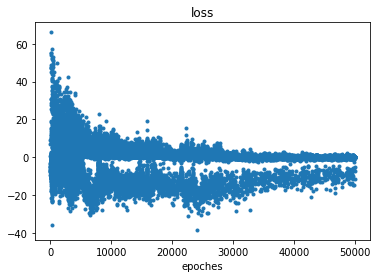

Computing stats: 100%|██████████| 100/100 [00:01<00:00, 52.49it/s]

Avg catches: 0.950
Avg episode lenght: 11.300
Avg number of agent seeing the prey 0.850
Avg communication: 0.589
Avg communication decision when prey seen: 0.652
Avg communication decision when prey not seen: 0.701


In [14]:
N = 3
grid_size = 5
T = 30
n_episodes = 50000

if "sess" in locals():
    sess.close()
    print("Sess closed")
tf.reset_default_graph()
sess = tf.Session()

commNet = CommNetPP(sess, N,  grid_size, lr=1e-3, alpha=0.06, memory = True)
env = PredatorPreyTask(N=N, grid_size=grid_size, detection_range=3, communication_cost=1e-5, step_cost=0.01, forbidden_cost=0.,
                       prey_detection_range=1, uncatched_cost=1., T=T, restart_range = 5)
history = commNet.reinforce_train(env, n_episodes=n_episodes, T=T)

W = 30

plt.title("Rewards")
plt.plot(history['reward'], '.')
plt.xlabel('epoches')
plt.show()

plt.title("Moving average of rewards")
plt.plot(np.convolve(history['reward'], np.ones(W), 'valid')/W, '.')
plt.xlabel('epoches')
plt.show()

plt.title("Catches (1: prey caught, 0: otherwise)")
plt.plot(history['terminal_state'], '.')
plt.xlabel('epoches')
plt.show()

plt.title("Moving average of catches")
plt.plot(np.convolve(history['terminal_state'],
                     np.ones(W), 'valid')/W, '.')
plt.xlabel('epoches')
plt.show()    

plt.title("loss")
plt.plot(history['loss'], '.')
plt.xlabel('epoches')
plt.show()

commNet.get_stats(100, T, env)


Catched: True


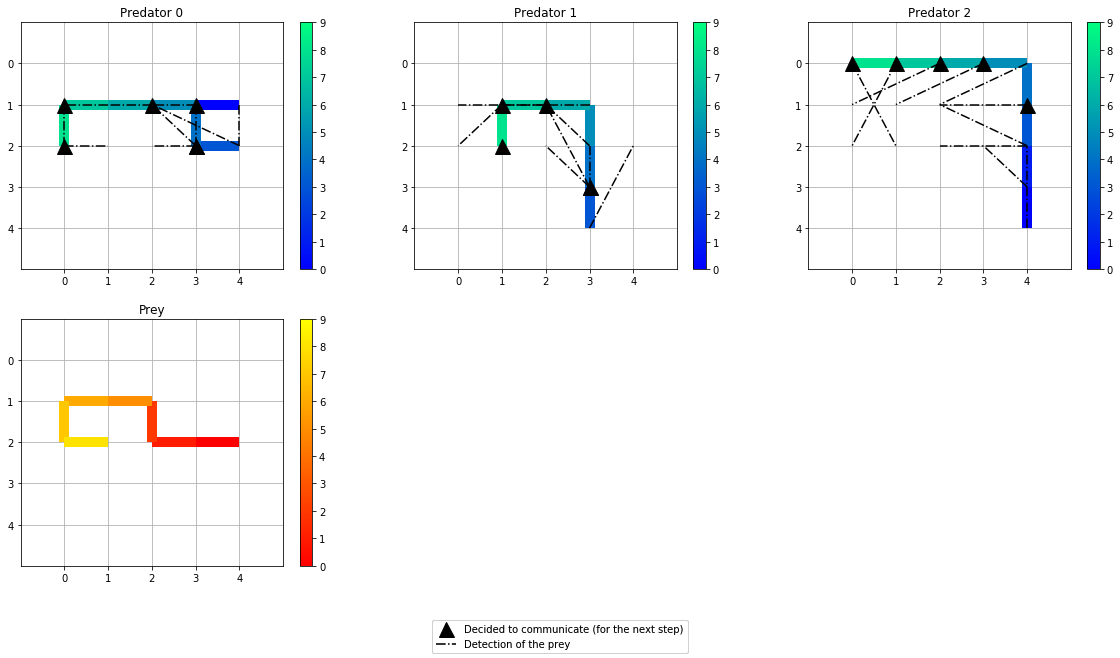

In [21]:
rollout = commNet.policy_rollout(T, env)

print("\nCatched: %s" % bool(rollout['terminal_state']))

pred_coord_history = np.array(env.pred_coord_history)
prey_coord_history = np.array(env.prey_coord_history)
comm_action_history = np.array(env.comm_action_history)
vision_history = np.array(env.vision_history)
plot_episode(pred_coord_history, prey_coord_history,
             comm_action_history, vision_history, grid_size)